In [1]:
using JuMP
using Gurobi
using CSV
using DataFrames

In [2]:
using Makie, CairoMakie
Makie.inline!(true); #make sure it shows in the notebook
using LinearAlgebra: norm

In [3]:
const GRB_ENV = Gurobi.Env(output_flag=1);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-06


### Data importation

In [4]:
centers = CSV.File("HW3_data//centers.csv",header=0) |> Tables.matrix;
stations = CSV.File("HW3_data//stations.csv",header=0) |> Tables.matrix;
landfills = CSV.File("HW3_data//landfills.csv",header=0) |> Tables.matrix;
q = CSV.File("HW3_data//q.csv",header=0) |> Tables.matrix;

centers2 = CSV.File("HW3_data//centers2.csv",header=0) |> Tables.matrix;
stations2 = CSV.File("HW3_data//stations2.csv",header=0) |> Tables.matrix;
landfills2 = CSV.File("HW3_data//landfills2.csv",header=0) |> Tables.matrix;
q2 = CSV.File("HW3_data//q2.csv",header=0) |> Tables.matrix;

centers_all = [centers;centers2];
stations_all = [stations;stations2];
landfills_all = [landfills;landfills2];
q_all = [q;q2];

n1 = size(centers)[1]
s1 = size(stations)[1]
m1 = size(landfills)[1]
n2 = size(centers2)[1]
s2 = size(stations2)[1]
m2 = size(landfills2)[1]
n_all = n1+n2;
s_all = s1+s2;
m_all = m1+m2;

# Problem Visualization

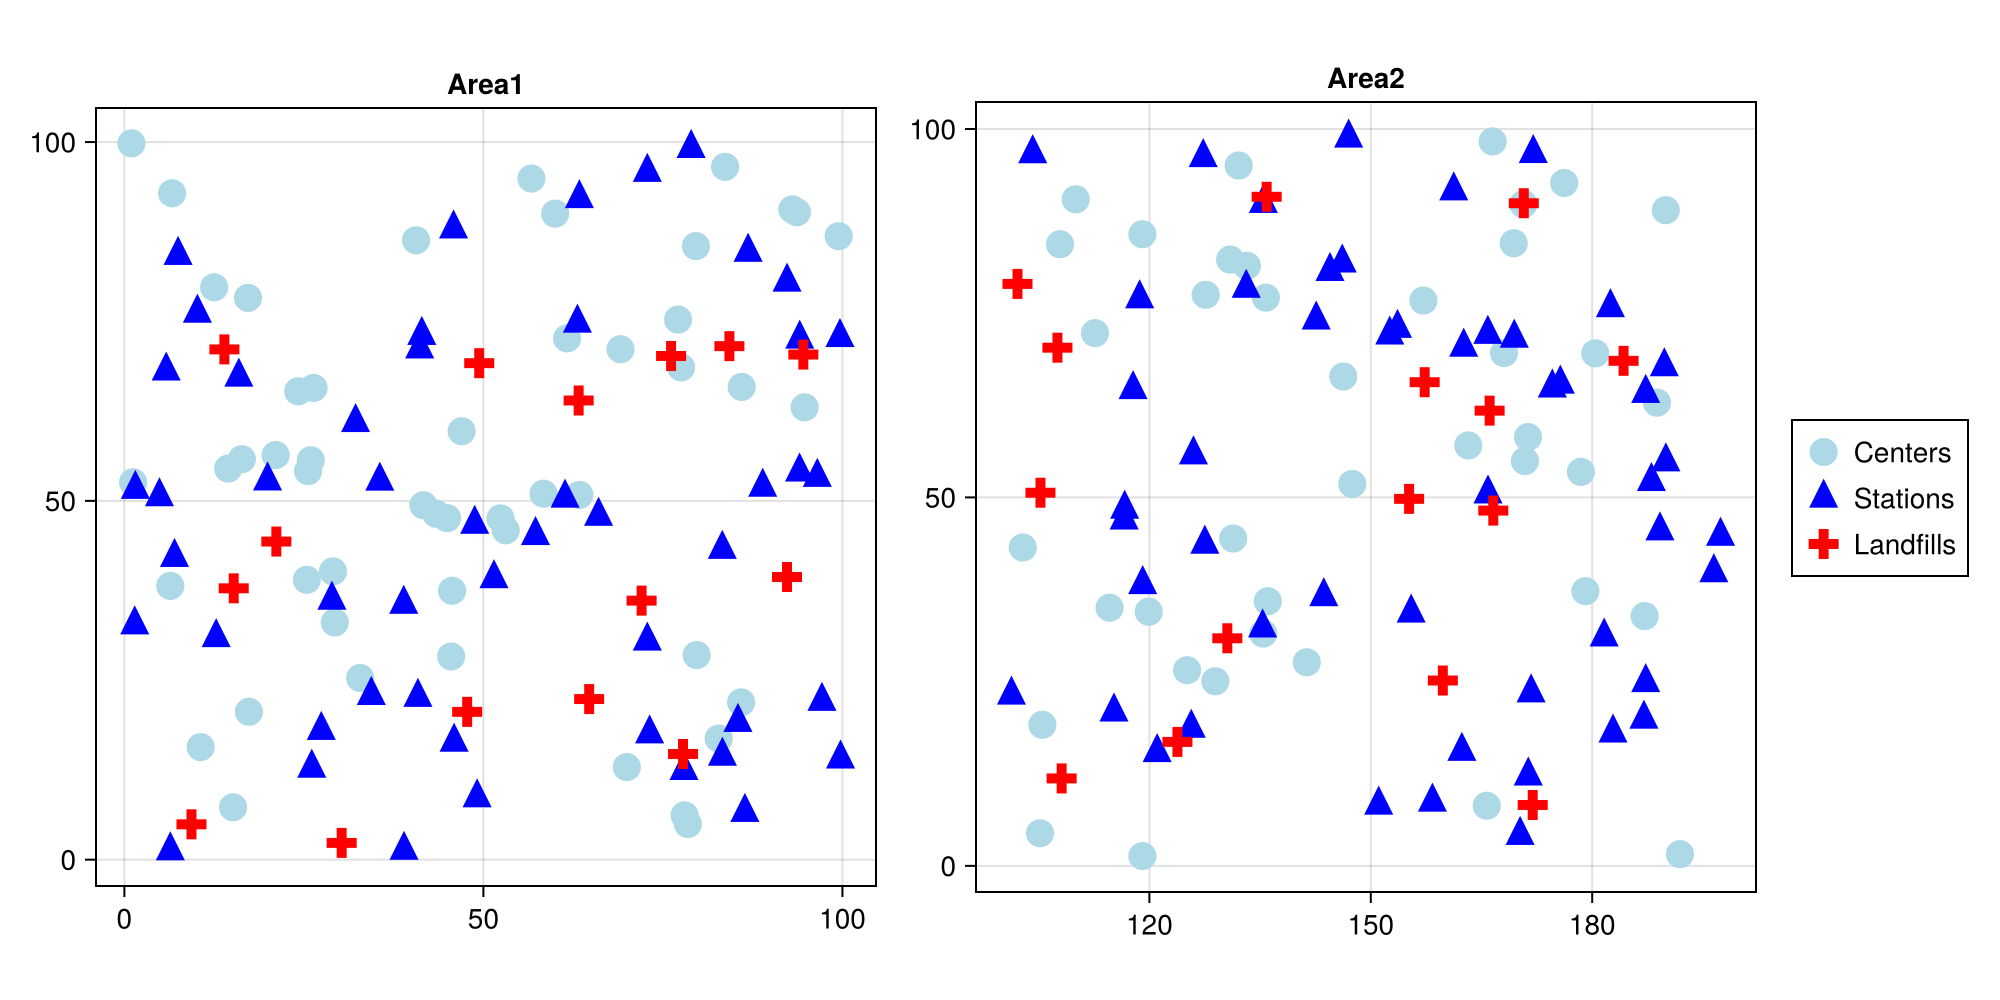

CairoMakie.Screen{IMAGE}


In [5]:
f_data = Figure(size = (1000,500)); 
ga = f_data[1, 1] = GridLayout()

a1 = Axis(f_data[1,1],aspect = DataAspect(), title = "Area1") 
a2 = Axis(f_data[1,2],aspect = DataAspect(), title = "Area2") 

scatter!(a1, centers[:,1], centers[:,2] , color = :lightblue, label = "Centers", markersize = 20)
scatter!(a1, stations[:,1], stations[:,2], color = :blue, marker = :utriangle, label = "Stations", markersize = 20)
scatter!(a1, landfills[:,1],landfills[:,2], color = :red, marker = :cross, label = "Landfills", markersize = 20)


scatter!(a2, centers2[:,1], centers2[:,2] , color = :lightblue, label = "Centers", markersize = 20)
scatter!(a2, stations2[:,1], stations2[:,2], color = :blue, marker = :utriangle, label = "Stations", markersize = 20)
scatter!(a2, landfills2[:,1],landfills2[:,2], color = :red, marker = :cross, label = "Landfills", markersize = 20)

Legend(f_data[1,3], a1, tellheight = false)

# scatter!(a2, centers_all[:,1], centers_all[:,2])

display(f_data)

In [6]:
d = [norm(centers[i,:] - landfills[j,:]) for i in eachindex(centers[:,1]), j in eachindex(landfills[:,1])]
i = 1
j = 2
dx = centers[i,1] - landfills[j,1]
dy = centers[i,2] - landfills[j,2]
@show dis = sqrt(dx^2  + dy ^2) 
@show d[i,j]

dis = sqrt(dx ^ 2 + dy ^ 2) = 52.24253747665785
d[i, j] = 52.24253747665785


52.24253747665785

In [7]:
function visualize_result(model, centers, landfills, stations, built_landfills, built_stations, q, c2l, c2s, s2l; 
        scale = 5, sx = 1000, sy = 1000)


n_centers = size(centers,1);
n_stations = size(stations, 1); 
n_landfills = size(landfills, 1);
    
f = Figure(size = (sx,sy)); 

@show totalcost = round((objective_value(model)), digits = 2)
a1 = Axis(f[1,1],aspect = DataAspect(),  title = "Total cost= $totalcost dollars", titlesize = 25 ) 

#for each assignment, draw a line between them 
for i in 1:n_centers
    for j in 1:n_landfills
        if c2l[i,j] > 0  
            lines!(a1,[ centers[i,1],landfills[j,1]] , [centers[i,2], landfills[j,2]], color = :blue, linewidth = scale*c2l[i,j])
        end
    end
end

for i in 1:n_centers
    for j in 1:n_stations
        if c2s[i,j] > 0 
            lines!(a1,[ centers[i,1],stations[j,1]] , [centers[i,2], stations[j,2]], color = :green, linewidth = scale*c2s[i,j])
        end
    end
end

for i in 1:n_stations
    for j in 1:n_landfills
        if s2l[i,j] > 0
            lines!(a1,[ stations[i,1],landfills[j,1]] , [stations[i,2], landfills[j,2]], color = :red, linewidth = scale*s2l[i,j])
        end
    end
end

# Draw built landfills and stations

scatter!(a1, centers[:,1], centers[:,2] , color = :lightblue, label = "Centers", markersize = 20 )
for i in 1:n_centers
    text!(a1, centers[i,1], centers[i,2], text = string(q[i]), fontsize = 10)
end
    
for i in 1:n_landfills 
    if built_landfills[i] == 1 
        scatter!(a1, landfills[i,1],landfills[i,2], color = :red, marker = :cross, label = "Landfills", markersize = 20 )
    else
        # scatter!(a1, landfills[i,1],landfills[i,2], color = :red, marker = :cross, label = "Landfills", markersize = 10, alpha = 0.5 )
    end
end


for i in 1:n_stations 
    if built_stations[i] == 1 
        scatter!(a1, stations[i,1], stations[i,2], color = :blue, marker = :utriangle, label = "Stations", markersize = 20 )
        text!(a1, stations[i,1], stations[i,2] , text = string(round(sum([c2s[k,i]*q[k] for k = 1:n_centers]), digits = 2)), fontsize = 15)
    else 
        scatter!(a1, stations[i,1], stations[i,2], color = :blue, marker = :utriangle, label = "Unbuild Stations", markersize = 10, alpha = 0.5 )
    end
end


Legend(f[1,2], a1, tellheight = false, unique = true)

return f , a1
end
# display(f, inline = true)


visualize_result (generic function with 1 method)

# Part A

Formulizing the model

In [8]:
modelA = Model(Gurobi.Optimizer); # Builds Gurobi model

# distance between center i and landfill j
d = [norm(centers[i,:] - landfills[j,:]) for i in eachindex(centers[:,1]), j in eachindex(landfills[:,1])]

# Define the variables
@variable(modelA, x[1:50,1:15] ≥ 0, Bin); #decision to send waste from station i to landfill j or not?
@variable(modelA, y[1:15] ≥ 0 , Bin) ; # decision to build the landfill or not?

# Define the objective
@objective(modelA, Min, sum( [ q[i]*d[i,j]*x[i,j] for i =1:50 for j = 1:15]))

# Build no more than 5 landfills
@constraint(modelA, c1 , sum(y) ≤ 5);

# Make sure every stations has 1, and only 1 ,landfill to go to
@constraint(modelA, c2[i = 1:50] , sum(x[i,:]) == 1) 

# Make sure that each landfill that built also serve those stations
@constraint(modelA, c3[i=1:50, j=1:15], x[i,j] ≤ y[j])

optimize!(modelA); # Optimize model
@show is_solved_and_feasible(modelA);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-06
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 24.0.0 24A348)

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 801 rows, 765 columns and 2265 nonzeros
Model fingerprint: 0x2d0e9940
Variable types: 0 continuous, 765 integer (765 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+03, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve time: 0.00s
Presolved: 801 rows, 765 columns, 2265 nonzeros
Variable types: 0 continuous, 765 integer (765 binary)
Found heuristic solution: objective 1152663.6471

Root relaxation: objective 8.404875e+05, 175 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

Check the optimization result

In [9]:
assignment = value.(x);
@show sum(assignment)
@show built_landfills = value.(y)
built = sum(value.(y))
@show built
println("###Built landfills###")
for i in 1:15 
    if built_landfills[i] == 1 
        println(i,": " , landfills[i,:])
    end
end

sum(assignment) = 50.0
built_landfills = value.(y) = [-0.0, -0.0, 1.0, 1.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, 0.0, -0.0, 1.0, 1.0, -0.0]
built = 5.0
###Built landfills###
3: [21.163, 44.331]
4: [63.265, 63.989]
7: [77.801, 14.727]
13: [84.261, 71.562]
14: [13.93, 71.108]


## Visualize the result

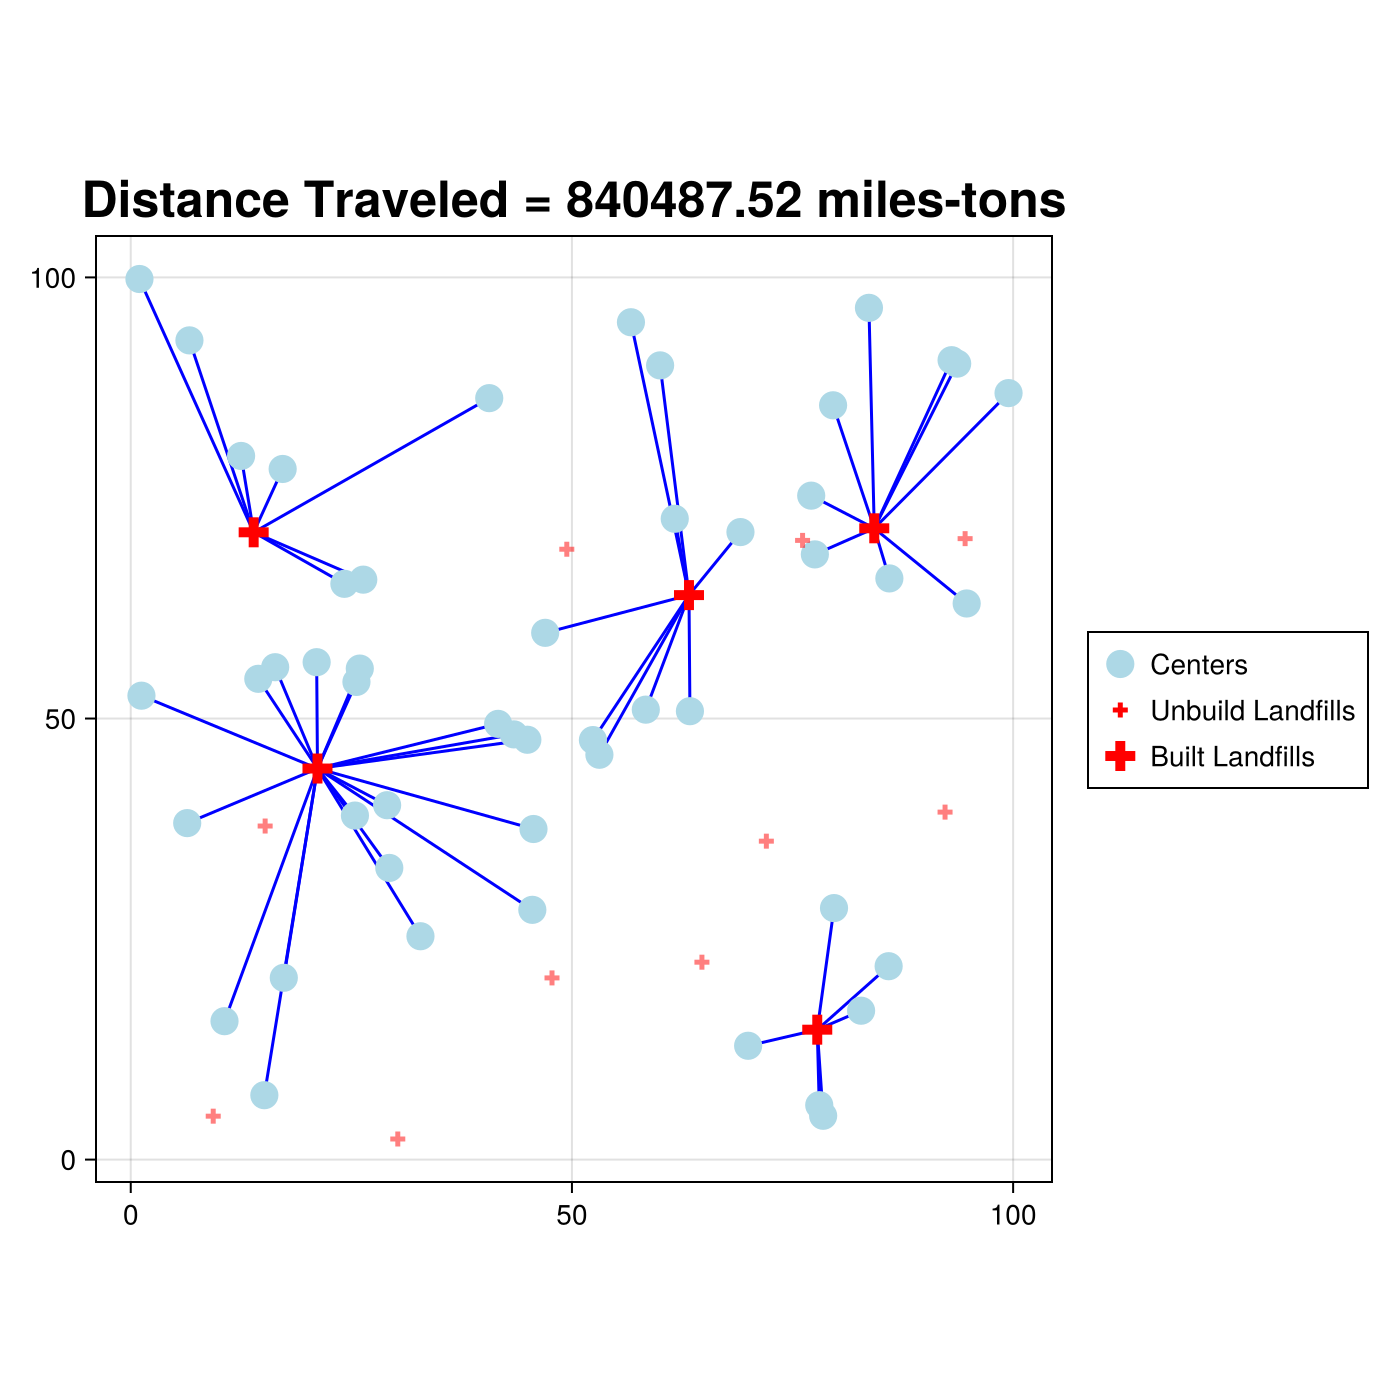

CairoMakie.Screen{IMAGE}


In [10]:
f_A = Figure(size = (700,700)); 
distance_traveled = (objective_value(modelA))
rounded_distance = round( distance_traveled, digits = 2) 
a1A = Axis(f_A[1,1],aspect = DataAspect(), title = "Distance Traveled = $rounded_distance miles-tons", titlesize = 25 ) 


#for each assignment, draw a line between them 
#plot them first so the nodes that are plotted later stay on top.
for i in 1:50
    for j in 1:15
        if assignment[i,j] == 1 
            lines!(a1A,[ centers[i,1],landfills[j,1]] , [centers[i,2], landfills[j,2]], color = :blue)
        end
    end
end
scatter!(a1A, centers[:,1], centers[:,2] , color = :lightblue, label = "Centers", markersize = 20)
for i in eachindex(landfills[:,1])
    if (built_landfills[i] == 1)
        scatter!(a1A, landfills[i,1],landfills[i,2], color = :red, marker = :cross, label = "Built Landfills", markersize = 20)
    else 
        scatter!(a1A, landfills[i,1],landfills[i,2], color = :red, marker = :cross, label = "Unbuild Landfills", markersize = 10, alpha = 0.5)
    end
end


Legend(f_A[1,2], a1A, tellheight = false, unique = true)

display(f_A)

# Part B

In [11]:
n_stations = size(stations, 1)
n_centers = size(centers, 1)
n_landfills = size(landfills, 1);
dist_center_to_landfill = [norm(centers[i, :] - landfills[j, :]) for i in 1:n_centers, j in 1:n_landfills]
dist_center_to_station = [norm(centers[i, :] - stations[k, :]) for i in 1:n_centers, k in 1:n_stations]
dist_station_to_landfill = [norm(stations[k, :] - landfills[j, :]) for k in 1:n_stations, j in 1:n_landfills];
modelB = Model(Gurobi.Optimizer)
@variable(modelB, y[1:n_landfills], Bin) # decision to build landfills
@variable(modelB, z[1:n_stations], Bin) # decision to build stations
@variable(modelB, x[1:n_centers, 1:n_landfills] >= 0)  # fraction from center to landfill
@variable(modelB, w[1:n_centers, 1:n_stations] >= 0)   # fraction from center to station
@variable(modelB, v[1:n_stations, 1:n_landfills] >= 0);# waste from station to landfill

@objective(modelB,
    Min,
    # centers to landfills Cost
    1*sum(dist_center_to_landfill[i, j] * q[i] * x[i, j] for i in 1:n_centers, j in 1:n_landfills) +
    # centers to stations Cost
    1*sum(dist_center_to_station[i, k] * q[i] * w[i, k] for i in 1:n_centers, k in 1:n_stations) +
    # stations to landfills Cost
    0.5 * sum(dist_station_to_landfill[k, j] * v[k, j] for k in 1:n_stations, j in 1:n_landfills) +
    # OP Cost
    10000 * sum(z[k] for k in 1:n_stations)
)

#Numbers of landfills
@constraint(modelB, sum(y[j] for j in 1:n_landfills) == 5)

#total waste got processed
for i in 1:n_centers
    @constraint(modelB, sum(x[i, j] for j in 1:n_landfills) + sum(w[i, k] for k in 1:n_stations) == 1)
end
#compact station capacity
for k in 1:n_stations
    @constraint(modelB, sum(q[i] * w[i, k] for i in 1:n_centers) <= 2000 * z[k])
end
#in = out
for k in 1:n_stations
    @constraint(modelB, sum(v[k, j] for j in 1:n_landfills) == sum(q[i] * w[i, k] for i in 1:n_centers))
end
#make sure landfill serves those compcat stations
for k in 1:n_stations, j in 1:n_landfills
    @constraint(modelB, v[k, j] <= y[j] * 1e8)  # 1e6 is a large constant (M)
end

#only send from centers to the built compact stations
for i in 1:n_centers, k in 1:n_stations
    @constraint(modelB, w[i, k] <= z[k])
end

#only send from centers to the built landfills
for i in 1:n_centers, j in 1:n_landfills
@constraint(modelB, x[i,j] ≤ y[j])
end

optimize!(modelB)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-06
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 24.0.0 24A348)

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 4151 rows, 4065 columns and 17065 nonzeros
Model fingerprint: 0x68656f6d
Variable types: 4000 continuous, 65 integer (65 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [1e+00, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 2401147.9666
Presolve time: 0.01s
Presolved: 4151 rows, 4065 columns, 17065 nonzeros
Variable types: 4000 continuous, 65 integer (65 binary)

Root relaxation: objective 7.454420e+05, 522 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/N

In [12]:
c2l = value.(x);
c2s = value.(w);
s2l = value.(v);
s2l = s2l./maximum(s2l)

built_landfills = value.(y) ;
built_stations = value.(z) ;
@show sum(built_landfills)
println("###Built landfills###")
println("Index    x    y")
for i in 1:15
 if built_landfills[i] == 1 
        println(i, ": ", landfills[i,:])
    end
end
println("###Built stations###")
println("Index    x    y")
for i in 1:50
 if built_stations[i] == 1 
        println(i, ": ", stations[i,:])
    end
end

sum(built_landfills) = 5.0
###Built landfills###
Index    x    y
3: [21.163, 44.331]
4: [63.265, 63.989]
7: [77.801, 14.727]
13: [84.261, 71.562]
14: [13.93, 71.108]
###Built stations###
Index    x    y
4: [63.366, 92.143]
12: [38.906, 35.617]
21: [86.866, 84.671]
23: [57.254, 45.196]
30: [12.781, 30.966]
31: [92.287, 80.505]
32: [48.784, 46.765]
39: [1.5279, 51.627]
45: [7.478, 84.236]


In [13]:
@show sum(c2l , dims = 2) + sum(c2s, dims = 2);

sum(c2l, dims = 2) + sum(c2s, dims = 2) = [1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 0.9999999999999999; 1.0; 1.0; 1.0; 1.0; 0.9999999999999999; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0;;]


totalcost = round(objective_value(model), digits = 2) = 808642.75


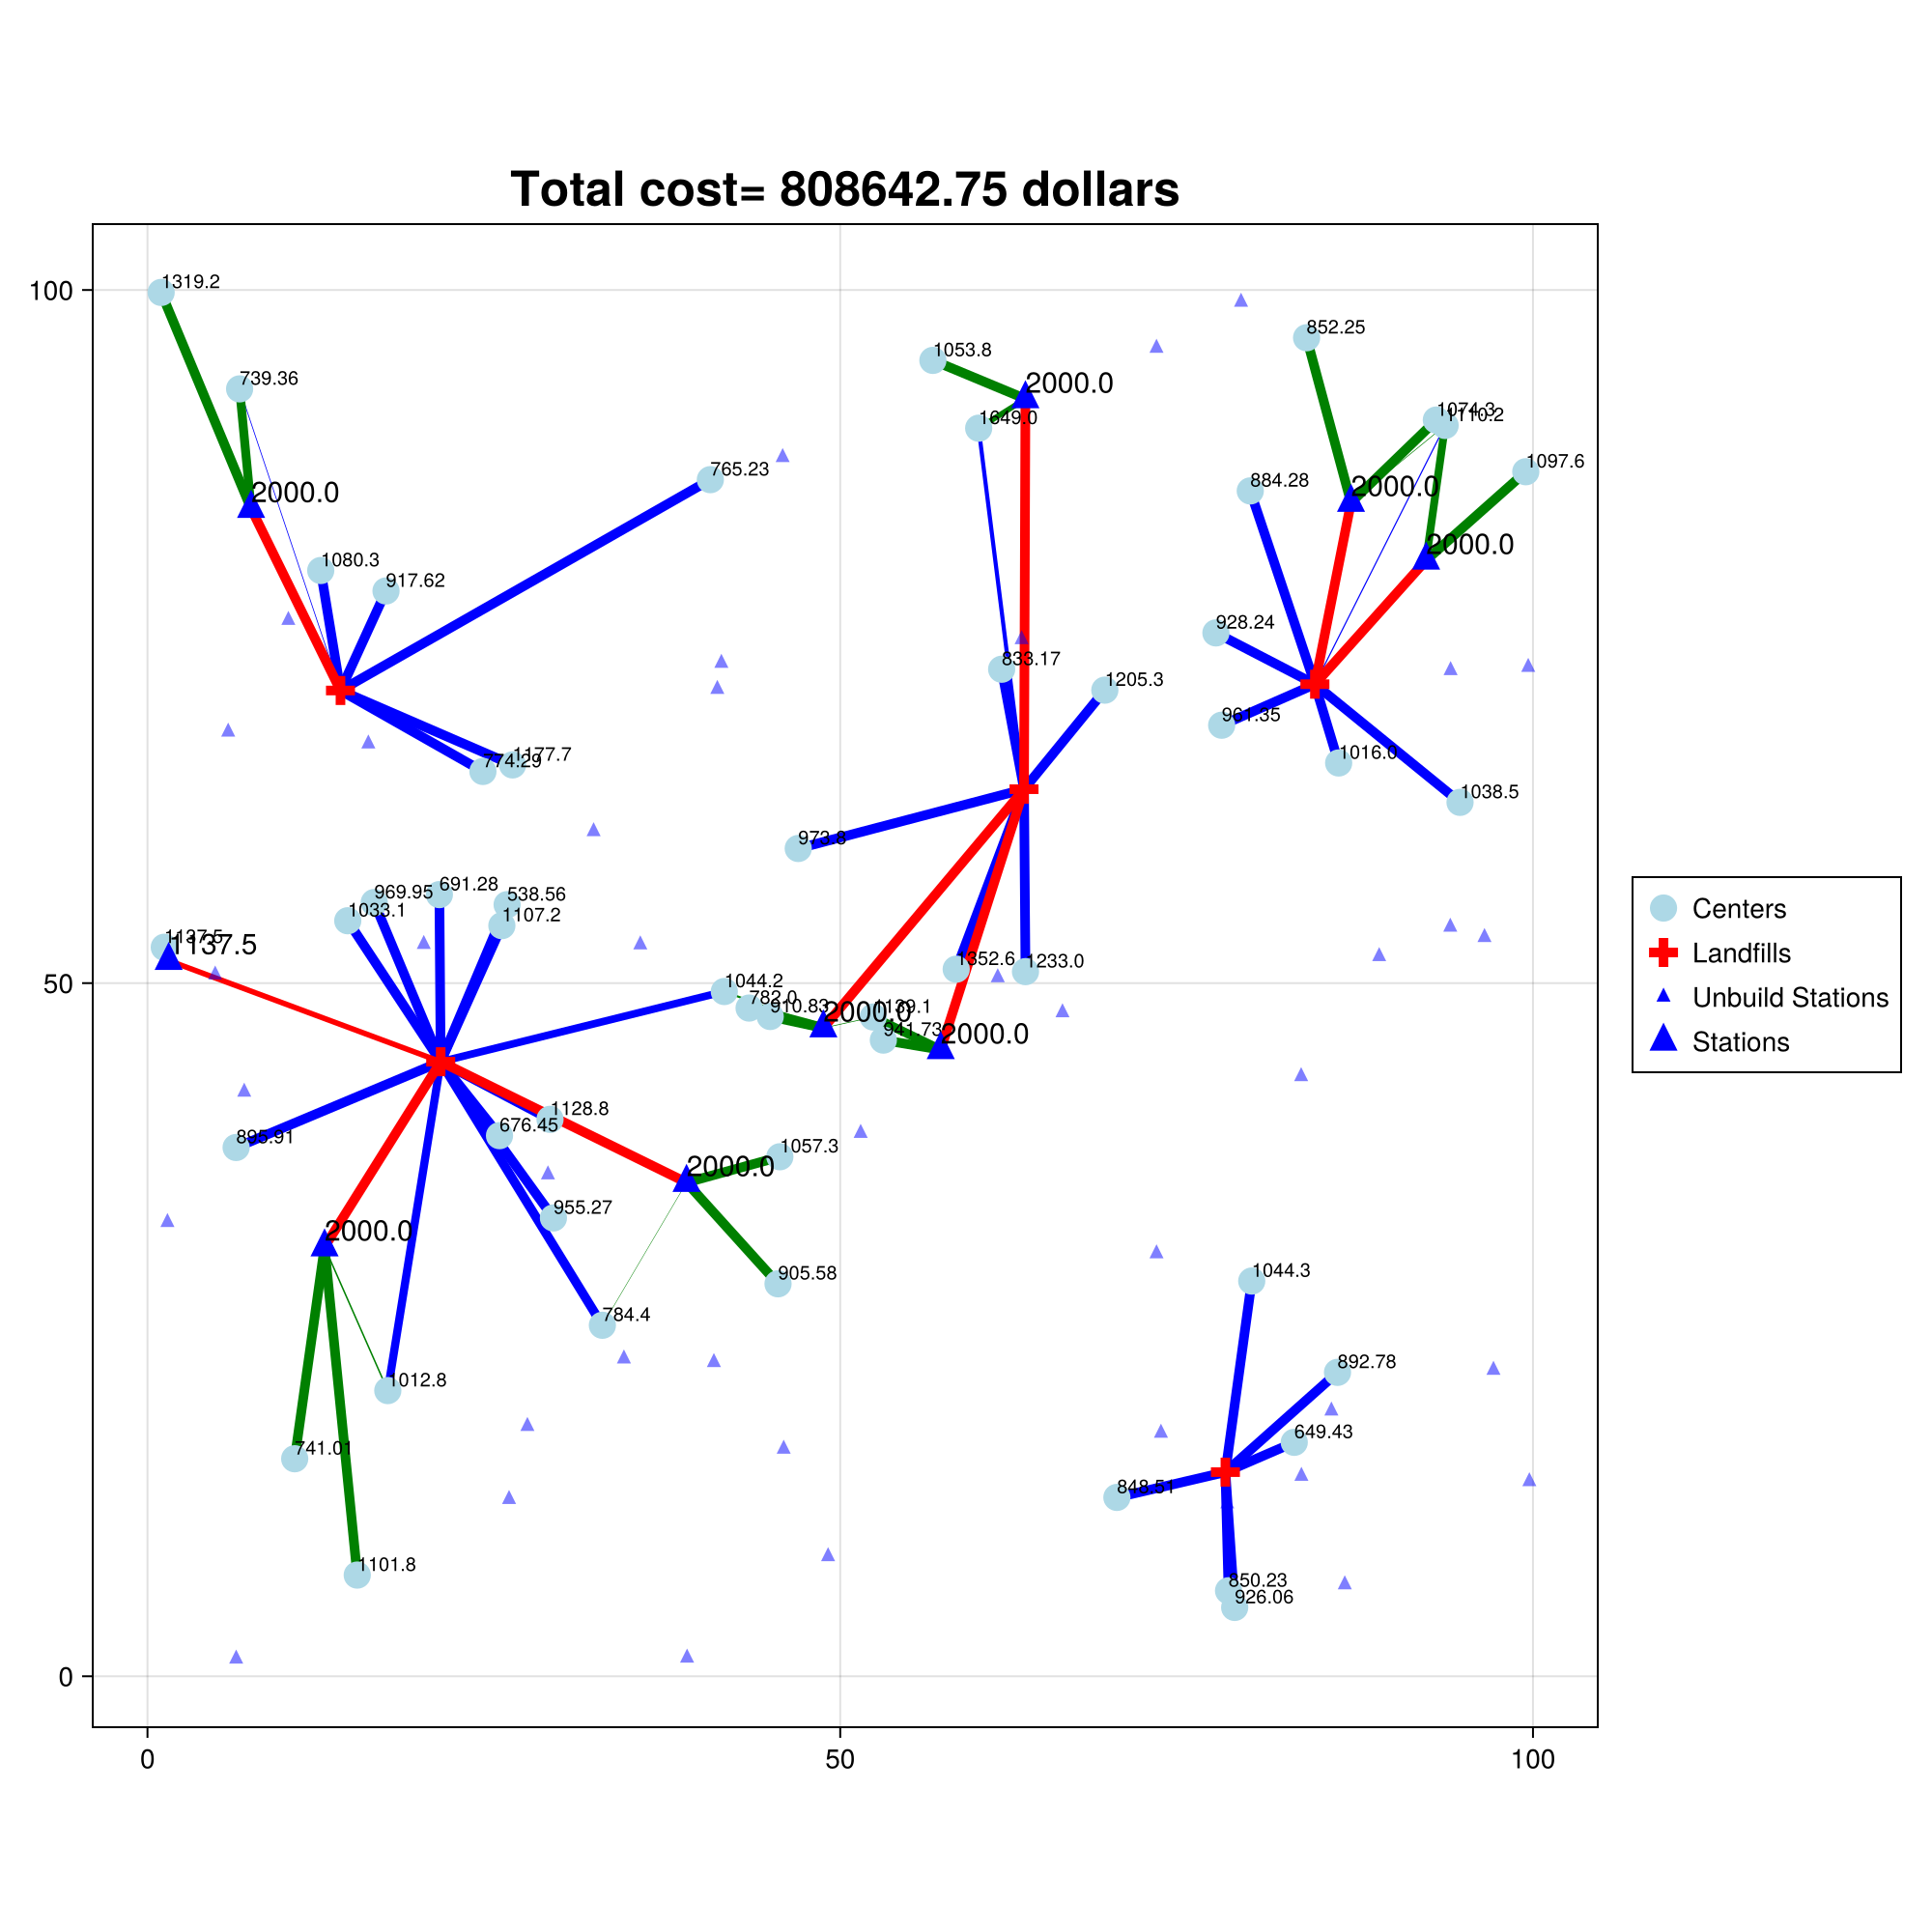

CairoMakie.Screen{IMAGE}


In [14]:
 f_B, axB = visualize_result(modelB, centers, landfills, stations, built_landfills, built_stations, q, c2l, c2s, s2l)
display(f_B)

In [15]:
Construction_cost = sum(10000*value.(z))
Transportation_cost = round(objective_value(modelB) - Construction_cost, digits = 2)
println("Daily (operation) cost: $Construction_cost dollars") 
println("Transportation cost: $Transportation_cost dollars")
distance_traveled =  round(value(1*sum(dist_center_to_landfill[i, j] * q[i] * x[i, j] for i in 1:n_centers, j in 1:n_landfills) +
    # centers to stations Cost
    sum(dist_center_to_station[i, k] * q[i] * w[i, k] for i in 1:n_centers, k in 1:n_stations) +
    # stations to landfills Cost
    sum(dist_station_to_landfill[k, j] * v[k, j] for k in 1:n_stations, j in 1:n_landfills) +
    # OP Cost
    10000 * sum(z[k] for k in 1:n_stations)), digits = 2)
println("Distance traveled: $distance_traveled miles-tons")

Daily (operation) cost: 90000.0 dollars
Transportation cost: 718642.75 dollars
Distance traveled: 966496.76 miles-tons


# Part C

In [16]:
modelC = Model(Gurobi.Optimizer); # Builds Gurobi model

# distance between center i and landfill j
d = [norm(centers2[i,:] - landfills2[j,:]) for i in eachindex(centers2[:,1]), j in eachindex(landfills2[:,1])]

# Define the variables
@variable(modelC, x[1:n2,1:15] ≥ 0, Bin); #decision to send waste from station i to landfill j or not?
@variable(modelC, y[1:15] ≥ 0 , Bin) ; # decision to build the landfill or not?

# Define the objective
@objective(modelC, Min, sum( [ q2[i]*d[i,j]*x[i,j] for i =1:n2 for j = 1:15]))

# Build no more than 5 landfills
@constraint(modelC, c1 , sum(y) ≤ 5);

# Make sure every stations has 1, and only 1 ,landfill to go to
@constraint(modelC, c2[i = 1:n2] , sum(x[i,:]) == 1) 

# Make sure that each landfill that built also serve those stations
@constraint(modelC, c3[i=1:n2, j=1:15], x[i,j] ≤ y[j])

optimize!(modelC); # Optimize model
@show is_solved_and_feasible(modelC);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-06
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 24.0.0 24A348)

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 641 rows, 615 columns and 1815 nonzeros
Model fingerprint: 0x7259fc51
Variable types: 0 continuous, 615 integer (615 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+02, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve time: 0.00s
Presolved: 641 rows, 615 columns, 1815 nonzeros
Variable types: 0 continuous, 615 integer (615 binary)
Found heuristic solution: objective 1821063.8210

Root relaxation: objective 1.220771e+06, 160 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

In [17]:
assignment = value.(x);
@show sum(assignment)
@show built_landfills_c1 = value.(y)
built = sum(value.(y))
@show built
println("###Built landfills###")
for i in 1:15 
    if built_landfills_c1[i] == 1 
        println(i,": " , landfills2[i,:])
    end
end

sum(assignment) = 40.0
built_landfills_c1 = value.(y) = [1.0, -0.0, -0.0, -0.0, -0.0, 1.0, -0.0, 0.0, 1.0, -0.0, -0.0, 0.0, 1.0, -0.0, 1.0]
built = 5.0
###Built landfills###
1: [171.94, 8.2604]
6: [170.73, 89.923]
9: [130.56, 30.882]
13: [135.89, 90.798]
15: [166.1, 61.775]


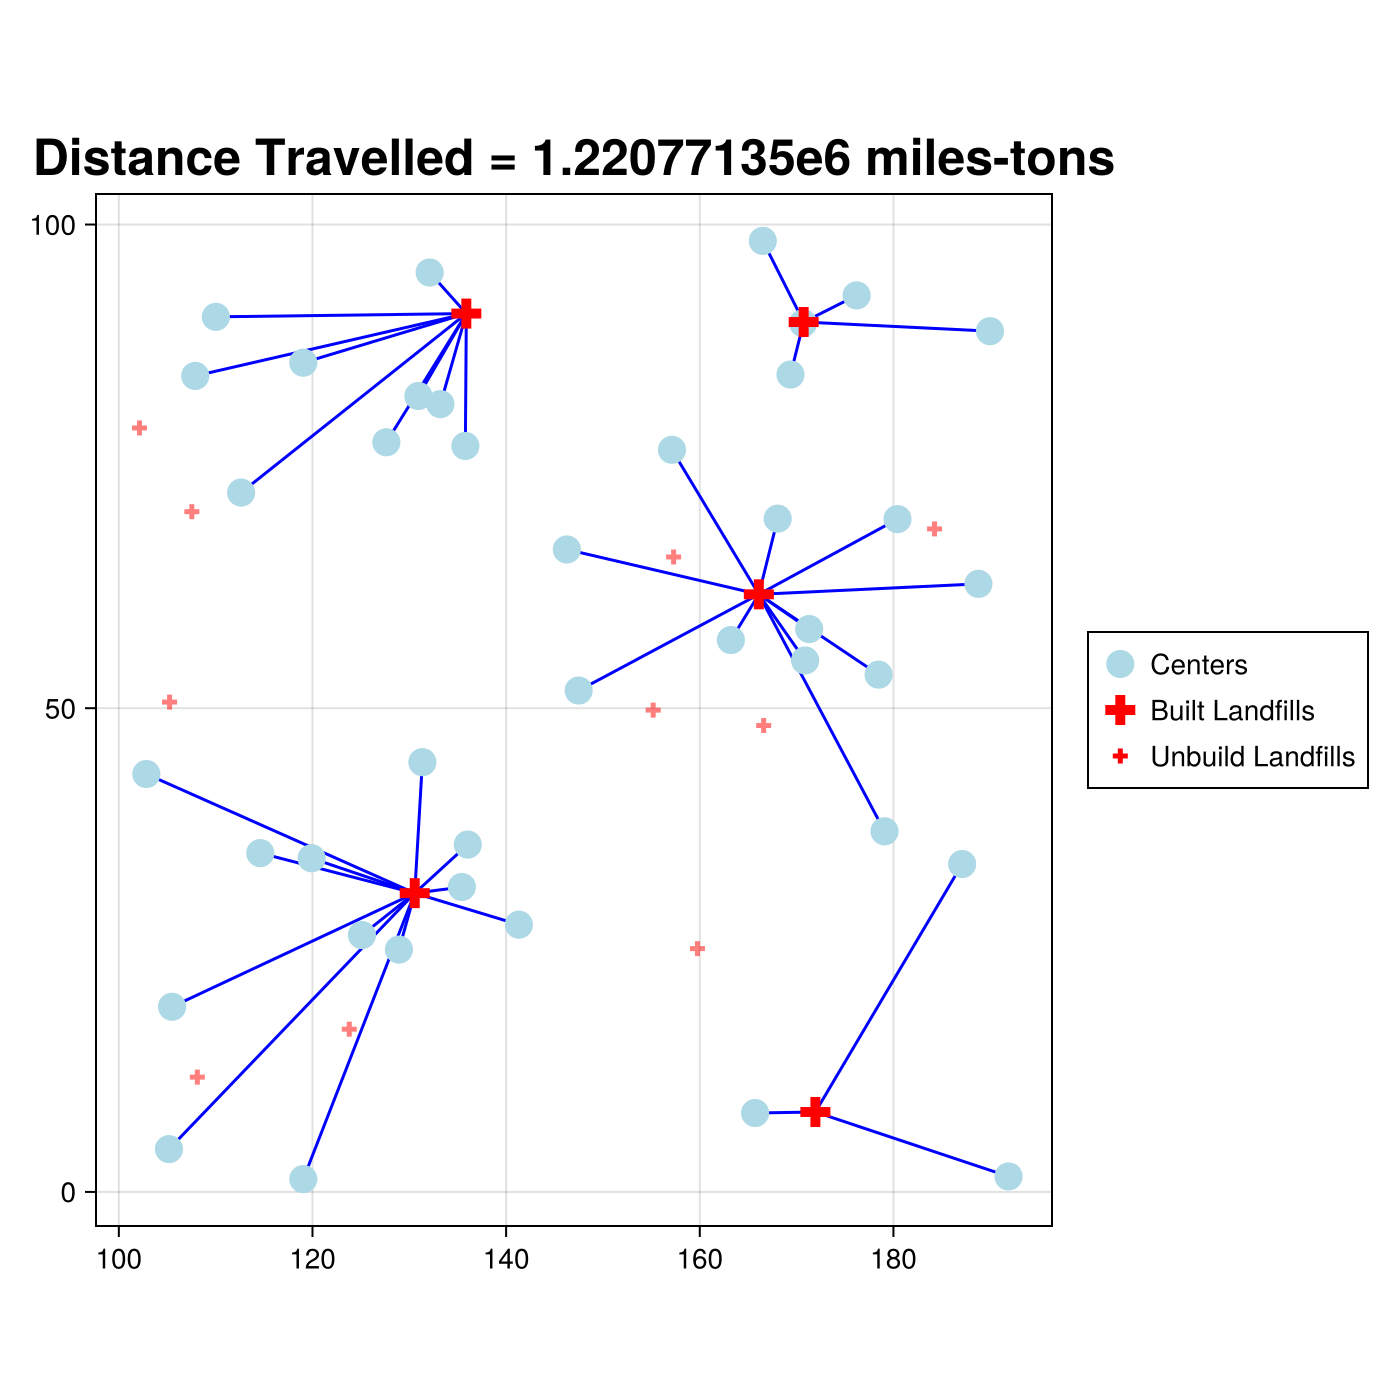

CairoMakie.Screen{IMAGE}


In [18]:
f_C = Figure(size = (700,700)); 

distance_traveled = (objective_value(modelC))
rounded_distance = round( distance_traveled, digits = 2) 
a1C = Axis(f_C[1,1],aspect = DataAspect(), title = "Distance Travelled = $rounded_distance miles-tons", titlesize = 25 ) 


#for each assignment, draw a line between them 
#plot them first so the nodes that are plotted later stay on top.
for i in 1:n2
    for j in 1:15
        if assignment[i,j] == 1 
            lines!(a1C,[ centers2[i,1],landfills2[j,1]] , [centers2[i,2], landfills2[j,2]], color = :blue)
        end
    end
end
scatter!(a1C, centers2[:,1], centers2[:,2] , color = :lightblue, label = "Centers", markersize = 20)
for i in eachindex(landfills2[:,1])
    if (built_landfills_c1[i] == 1)
        scatter!(a1C, landfills2[i,1],landfills2[i,2], color = :red, marker = :cross, label = "Built Landfills", markersize = 20)
    else 
        scatter!(a1C, landfills2[i,1],landfills2[i,2], color = :red, marker = :cross, label = "Unbuild Landfills", markersize = 10, alpha = 0.5)
    end
end


Legend(f_C[1,2], a1C, tellheight = false, unique = true)

display(f_C)

In [19]:
n_stations = size(stations2, 1)
n_centers = size(centers2, 1)
n_landfills = size(landfills2, 1);
dist_center_to_landfill = [norm(centers2[i, :] - landfills2[j, :]) for i in 1:n_centers, j in 1:n_landfills]
dist_center_to_station = [norm(centers2[i, :] - stations2[k, :]) for i in 1:n_centers, k in 1:n_stations]
dist_station_to_landfill = [norm(stations2[k, :] - landfills2[j, :]) for k in 1:n_stations, j in 1:n_landfills];
modelC = Model(Gurobi.Optimizer)
@variable(modelC, y[1:n_landfills], Bin) # decision to build landfills
@variable(modelC, z[1:n_stations], Bin) # decision to build stations
@variable(modelC, x[1:n_centers, 1:n_landfills] >= 0)  # fraction from center to landfill
@variable(modelC, w[1:n_centers, 1:n_stations] >= 0)   # fraction from center to station
@variable(modelC, v[1:n_stations, 1:n_landfills] >= 0);# waste from station to landfill

@objective(modelC,
    Min,
    # centers to landfills Cost
    1*sum(dist_center_to_landfill[i, j] * q2[i] * x[i, j] for i in 1:n_centers, j in 1:n_landfills) +
    # centers to stations Cost
    1*sum(dist_center_to_station[i, k] * q2[i] * w[i, k] for i in 1:n_centers, k in 1:n_stations) +
    # stations to landfills Cost
    0.5 * sum(dist_station_to_landfill[k, j] * v[k, j] for k in 1:n_stations, j in 1:n_landfills) +
    # OP Cost
    10000 * sum(z[k] for k in 1:n_stations)
)

#Numbers of landfills
@constraint(modelC, sum(y[j] for j in 1:n_landfills) == 5)

#total waste got processed
for i in 1:n_centers
    @constraint(modelC, sum(x[i, j] for j in 1:n_landfills) + sum(w[i, k] for k in 1:n_stations) == 1)
end
#compact station capacity
for k in 1:n_stations
    @constraint(modelC, sum(q2[i] * w[i, k] for i in 1:n_centers) <= 2000 * z[k])
end
#in = out
for k in 1:n_stations
    @constraint(modelC, sum(v[k, j] for j in 1:n_landfills) == sum(q2[i] * w[i, k] for i in 1:n_centers))
end
#make sure landfill serves those compcat stations
for k in 1:n_stations, j in 1:n_landfills
    @constraint(modelC, v[k, j] <= y[j] * 1e8)  # 1e6 is a large constant (M)
end

#only send from centers to the built compact stations
for i in 1:n_centers, k in 1:n_stations
    @constraint(modelC, w[i, k] <= z[k])
end

#only send from centers to the built landfills
for i in 1:n_centers, j in 1:n_landfills
    @constraint(modelC, x[i,j] ≤ y[j])
end

optimize!(modelC)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-06
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 24.0.0 24A348)

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 3491 rows, 3415 columns and 14115 nonzeros
Model fingerprint: 0x68beaf06
Variable types: 3350 continuous, 65 integer (65 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [5e-01, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 3262000.1728
Presolve removed 850 rows and 0 columns
Presolve time: 0.01s
Presolved: 2641 rows, 3415 columns, 12415 nonzeros
Variable types: 3350 continuous, 65 integer (65 binary)

Root relaxation: objective 1.007961e+06, 408 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth I

In [20]:
c2l = value.(x);
c2s = value.(w);
s2l = value.(v);
s2l = s2l./maximum(s2l)

built_landfills_c2 = value.(y) ;
built_stations_c2 = value.(z) ;
@show sum(built_landfills_c2)
println("###Built landfills###")
println("Index    x    y")
for i in 1:15
 if built_landfills_c2[i] == 1 
        println(i, ": ", landfills2[i,:])
    end
end
println("###Built stations###")
println("Index    x    y")
for i in 1:50
 if built_stations_c2[i] == 1 
        println(i, ": ", stations2[i,:])
    end
end

sum(built_landfills_c2) = 5.0
###Built landfills###
Index    x    y
6: [170.73, 89.923]
8: [108.11, 11.864]
9: [130.56, 30.882]
13: [135.89, 90.798]
15: [166.1, 61.775]
###Built stations###
Index    x    y
6: [182.82, 18.048]
7: [119.09, 38.195]
24: [181.62, 31.085]
31: [158.35, 8.6711]
32: [187.25, 64.139]
36: [118.68, 76.979]


totalcost = round(objective_value(model), digits = 2) = 1.15176123e6
built_landfills_index1 = Any[1, 6, 9, 13, 15]
built_landfills_index2 = Any[6, 8, 9, 13, 15]
i = 1


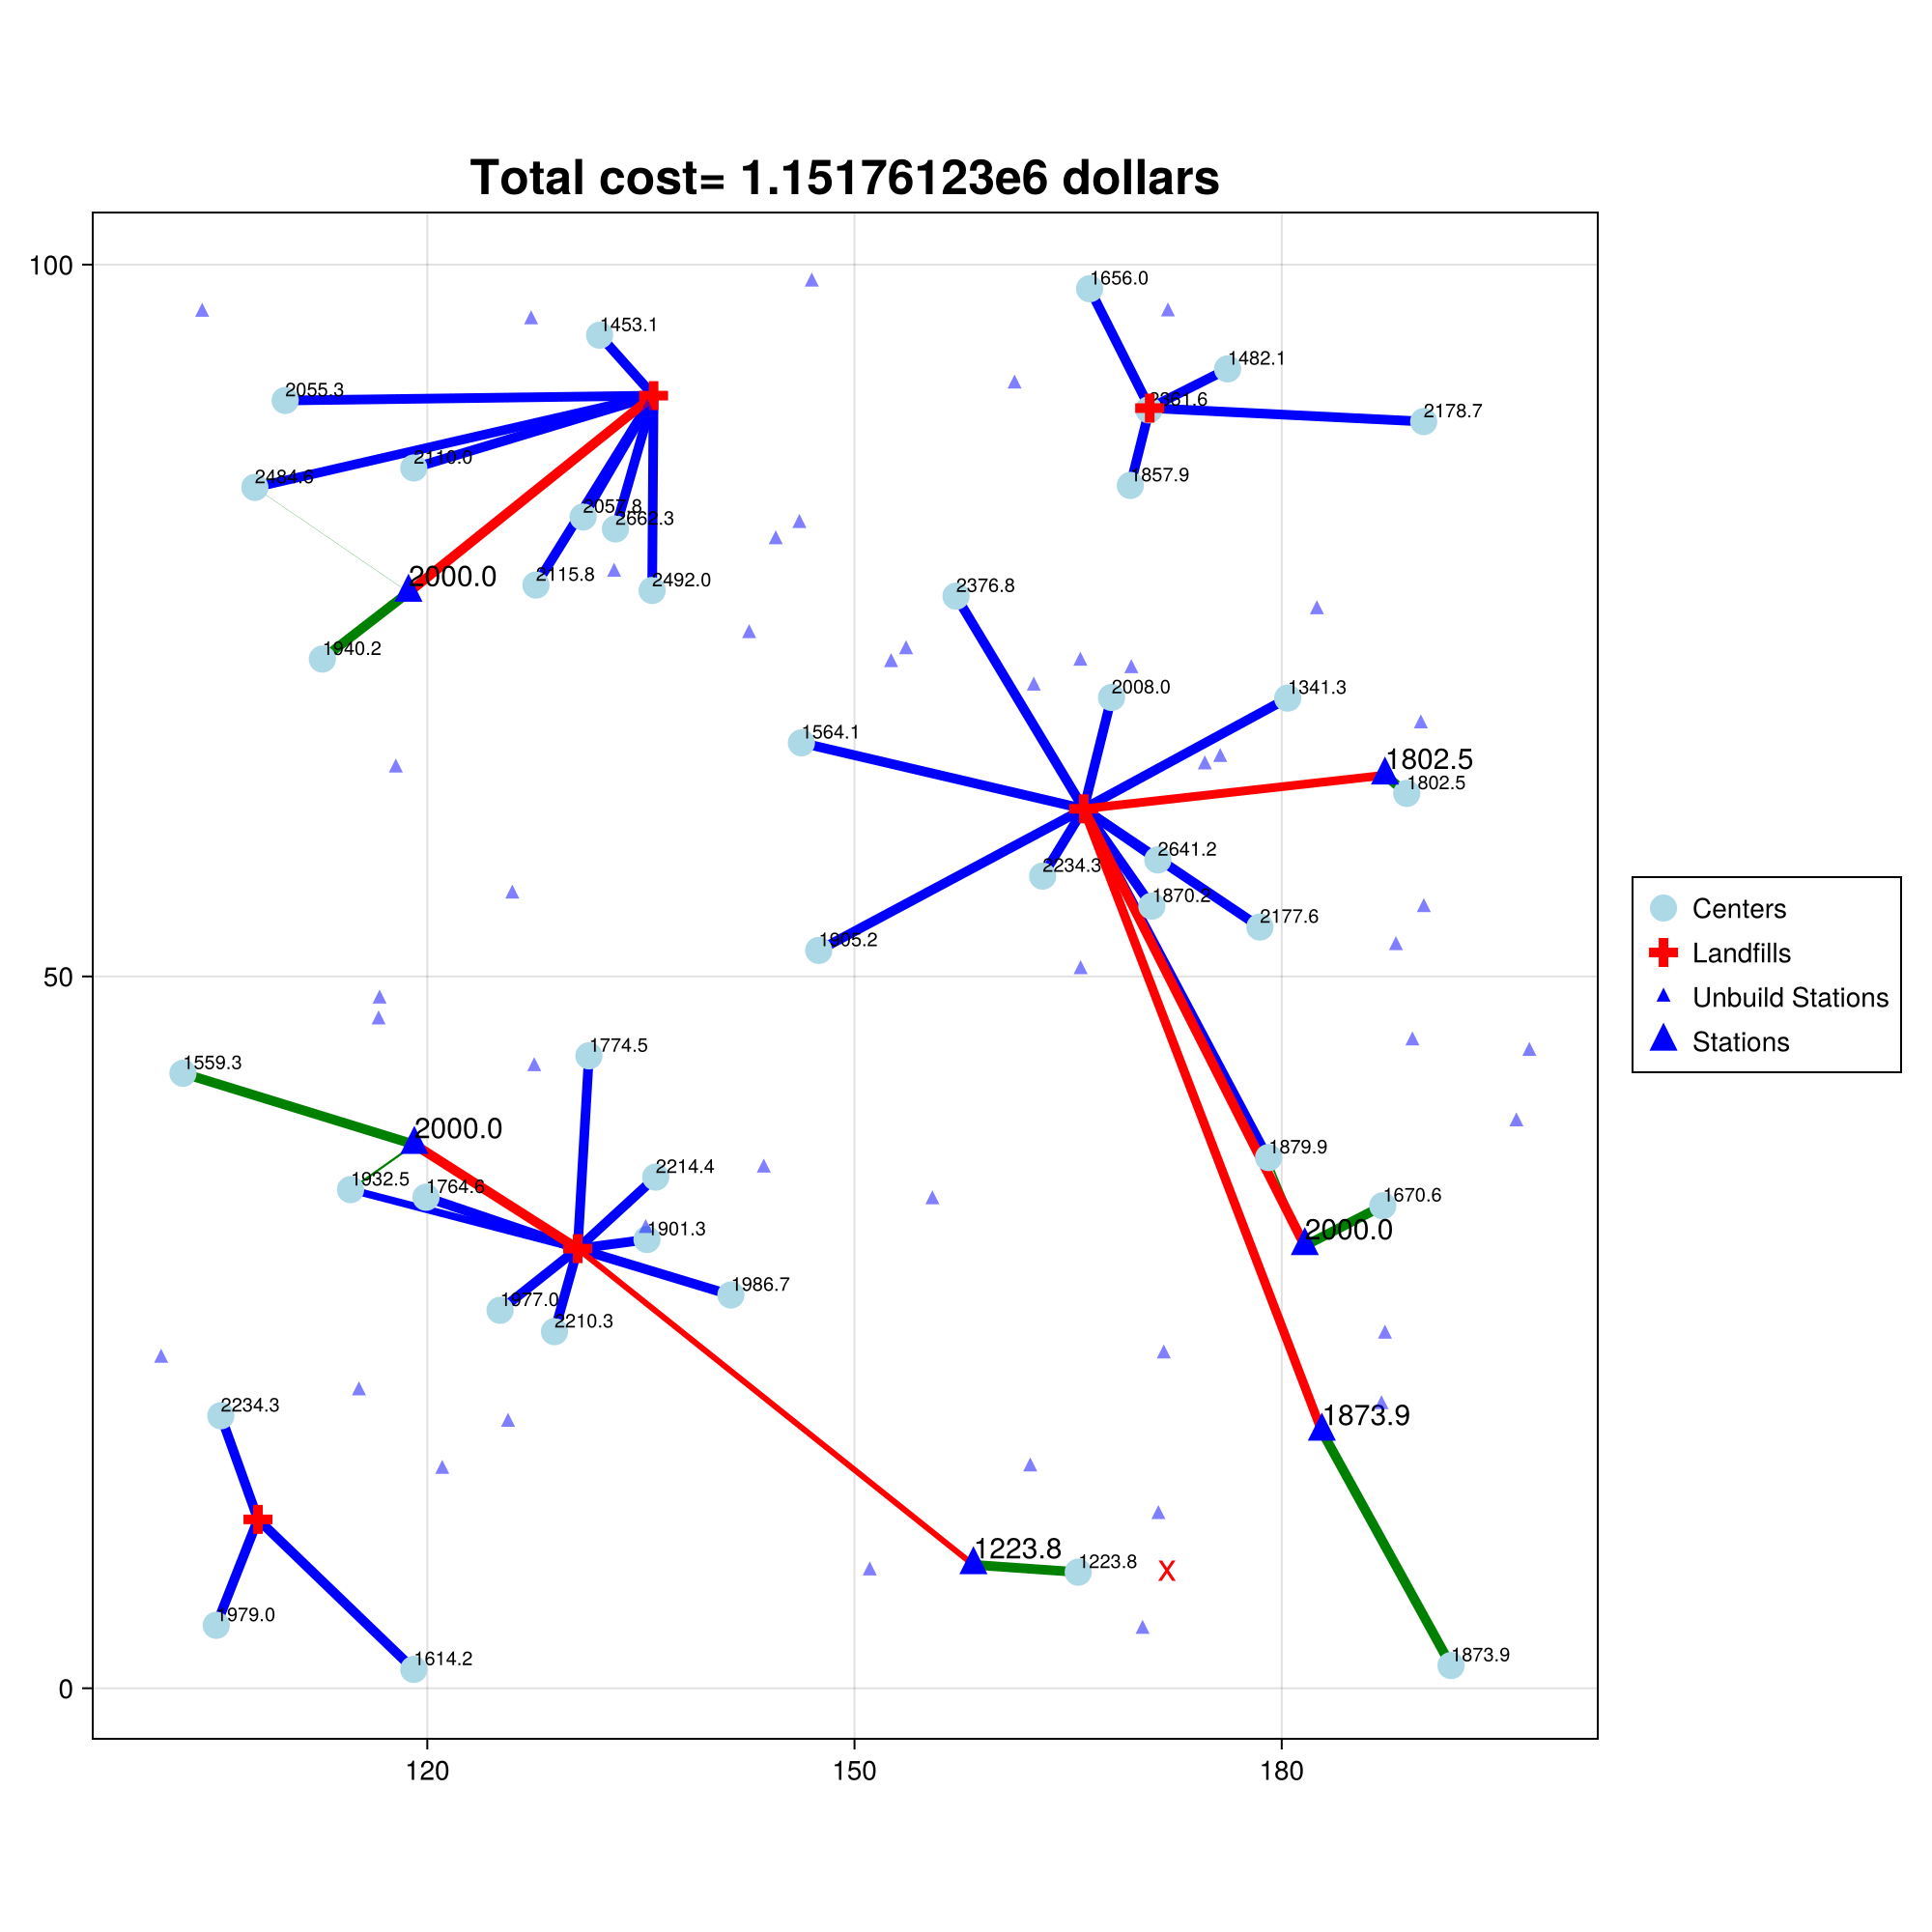

CairoMakie.Screen{IMAGE}


In [21]:
f_C, ax_c = visualize_result(modelC, centers2, landfills2, stations2, built_landfills_c2, built_stations_c2, q2, c2l, c2s, s2l)
#add the previous landfills that's not in the current one 
built_landfills_index1 = []
built_landfills_index2 = [] 
for i in 1:15
 if built_landfills_c1[i] == 1 
    push!(built_landfills_index1, i)
    end
 if built_landfills_c2[i] == 1 
    push!(built_landfills_index2, i)
    end
end
@show built_landfills_index1
@show built_landfills_index2
for i in built_landfills_index1
    if i ∉ built_landfills_index2
        @show i
        scatter!(ax_c, landfills2[i,1], landfills2[i,2], color = :red, markersize = 20, marker = 'x')
    end
end
        
display(f_C, inline = true)

In [22]:
Construction_cost = sum(10000*value.(z))
Transportation_cost = round(objective_value(modelC) - Construction_cost, digits = 2)
println("Daily (operation) cost: $Construction_cost dollars") 
println("Transportation cost: $Transportation_cost dollars")
distance_traveled =  round(value(1*sum(dist_center_to_landfill[i, j] * q2[i] * x[i, j] for i in 1:n_centers, j in 1:n_landfills) +
    # centers to stations Cost
    sum(dist_center_to_station[i, k] * q2[i] * w[i, k] for i in 1:n_centers, k in 1:n_stations) +
    # stations to landfills Cost
    sum(dist_station_to_landfill[k, j] * v[k, j] for k in 1:n_stations, j in 1:n_landfills) +
    # OP Cost
    10000 * sum(z[k] for k in 1:n_stations)), digits = 2)
println("Distance traveled: $distance_traveled miles-tons")

Daily (operation) cost: 60000.0 dollars
Transportation cost: 1.09176123e6 dollars
Distance traveled: 1.30663841e6 miles-tons


## part f

In [23]:
stations_total = vcat(stations, stations2)
centers_total = vcat(centers, centers2) 
landfills_total = vcat(landfills, landfills2)
q_total = vcat(q,q2)

90×1 Matrix{Float64}:
  538.56
  926.06
  848.51
  910.83
 1053.8
  969.95
 1044.2
 1057.3
 1097.6
  961.35
  955.27
 1012.8
  917.62
    ⋮
 1656.0
 2234.3
 2214.4
 1986.7
 1901.3
 2055.3
 2057.8
 2484.6
 1559.3
 1977.0
 2492.0
 1802.5

In [24]:
@show n_stations = size(stations_total, 1)
@show n_centers = size(centers_total, 1)
@show n_landfills = size(landfills_total, 1);
dist_center_to_landfill = [norm(centers_total[i, :] - landfills_total[j, :]) for i in 1:n_centers, j in 1:n_landfills]
dist_center_to_station = [norm(centers_total[i, :] - stations_total[k, :]) for i in 1:n_centers, k in 1:n_stations]
dist_station_to_landfill = [norm(stations_total[k, :] - landfills_total[j, :]) for k in 1:n_stations, j in 1:n_landfills];
modelC_f = Model(Gurobi.Optimizer)
@variable(modelC_f, y[1:n_landfills], Bin) # decision to build landfills
@variable(modelC_f, z[1:n_stations], Bin) # decision to build stations
@variable(modelC_f, x[1:n_centers, 1:n_landfills] >= 0)  # fraction from center to landfill
@variable(modelC_f, w[1:n_centers, 1:n_stations] >= 0)   # fraction from center to station
@variable(modelC_f, v[1:n_stations, 1:n_landfills] >= 0);# waste from station to landfill

@objective(modelC_f,
    Min,
    # centers to landfills Cost
    1*sum(dist_center_to_landfill[i, j] * q_total[i] * x[i, j] for i in 1:n_centers, j in 1:n_landfills) +
    # centers to stations Cost
    1*sum(dist_center_to_station[i, k] * q_total[i] * w[i, k] for i in 1:n_centers, k in 1:n_stations) +
    # stations to landfills Cost
    0.5 * sum(dist_station_to_landfill[k, j] * v[k, j] for k in 1:n_stations, j in 1:n_landfills) +
    # OP Cost
    10000 * sum(z[k] for k in 1:n_stations)
)

#Numbers of landfills
@constraint(modelC_f, sum(y[j] for j in 1:n_landfills) ≤ 10)

#total waste got processed
for i in 1:n_centers
    @constraint(modelC_f, sum(x[i, j] for j in 1:n_landfills) + sum(w[i, k] for k in 1:n_stations) == 1)
end
#compact station capacity
for k in 1:n_stations
    @constraint(modelC_f, sum(q_total[i] * w[i, k] for i in 1:n_centers) <= 2000 * z[k])
end
#in = out
for k in 1:n_stations
    @constraint(modelC_f, sum(v[k, j] for j in 1:n_landfills) == sum(q_total[i] * w[i, k] for i in 1:n_centers))
end
#make sure landfill serves those compcat stations
for k in 1:n_stations, j in 1:n_landfills
    @constraint(modelC_f, v[k, j] <= y[j] * 1e8)  # 1e6 is a large constant (M)
end

#only send from centers to the built compact stations
for i in 1:n_centers, k in 1:n_stations
    @constraint(modelC_f, w[i, k] <= z[k])
end

#only send from centers to the built landfills
for i in 1:n_centers, j in 1:n_landfills
    @constraint(modelC_f, x[i,j] ≤ y[j])
end

optimize!(modelC_f)

n_stations = size(stations_total, 1) = 100
n_centers = size(centers_total, 1) = 90
n_landfills = size(landfills_total, 1) = 30
Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-06
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 24.0.0 24A348)

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 14991 rows, 14830 columns and 62230 nonzeros
Model fingerprint: 0x344f7062
Variable types: 14700 continuous, 130 integer (130 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [5e-01, 5e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 1700 rows and 0 columns
Presolve time: 0.08s
Presolved: 13291 rows, 14830 columns, 58830 nonzeros
Variable types: 14700 continuous, 130 integer (130 binary)
Found heuristic solution: objective 4381926.7120
Found heuristic solution: objective 3115814.3993

Roo

In [25]:
c2l = value.(x);
c2s = value.(w);
s2l = value.(v);
s2l = s2l./maximum(s2l)

built_landfills_total = value.(y) ;
built_stations_total = value.(z) ;
@show sum(built_landfills_c2)
println("###Built landfills###")
println("Index    x    y")
for i in 1:15
 if built_landfills_c2[i] == 1 
        println(i, ": ", landfills2[i,:])
    end
end
println("###Built stations###")
println("Index    x    y")
for i in 1:50
 if built_stations_c2[i] == 1 
        println(i, ": ", stations2[i,:])
    end
end

sum(built_landfills_c2) = 5.0
###Built landfills###
Index    x    y
6: [170.73, 89.923]
8: [108.11, 11.864]
9: [130.56, 30.882]
13: [135.89, 90.798]
15: [166.1, 61.775]
###Built stations###
Index    x    y
6: [182.82, 18.048]
7: [119.09, 38.195]
24: [181.62, 31.085]
31: [158.35, 8.6711]
32: [187.25, 64.139]
36: [118.68, 76.979]


totalcost = round(objective_value(model), digits = 2) = 1.8653845e6


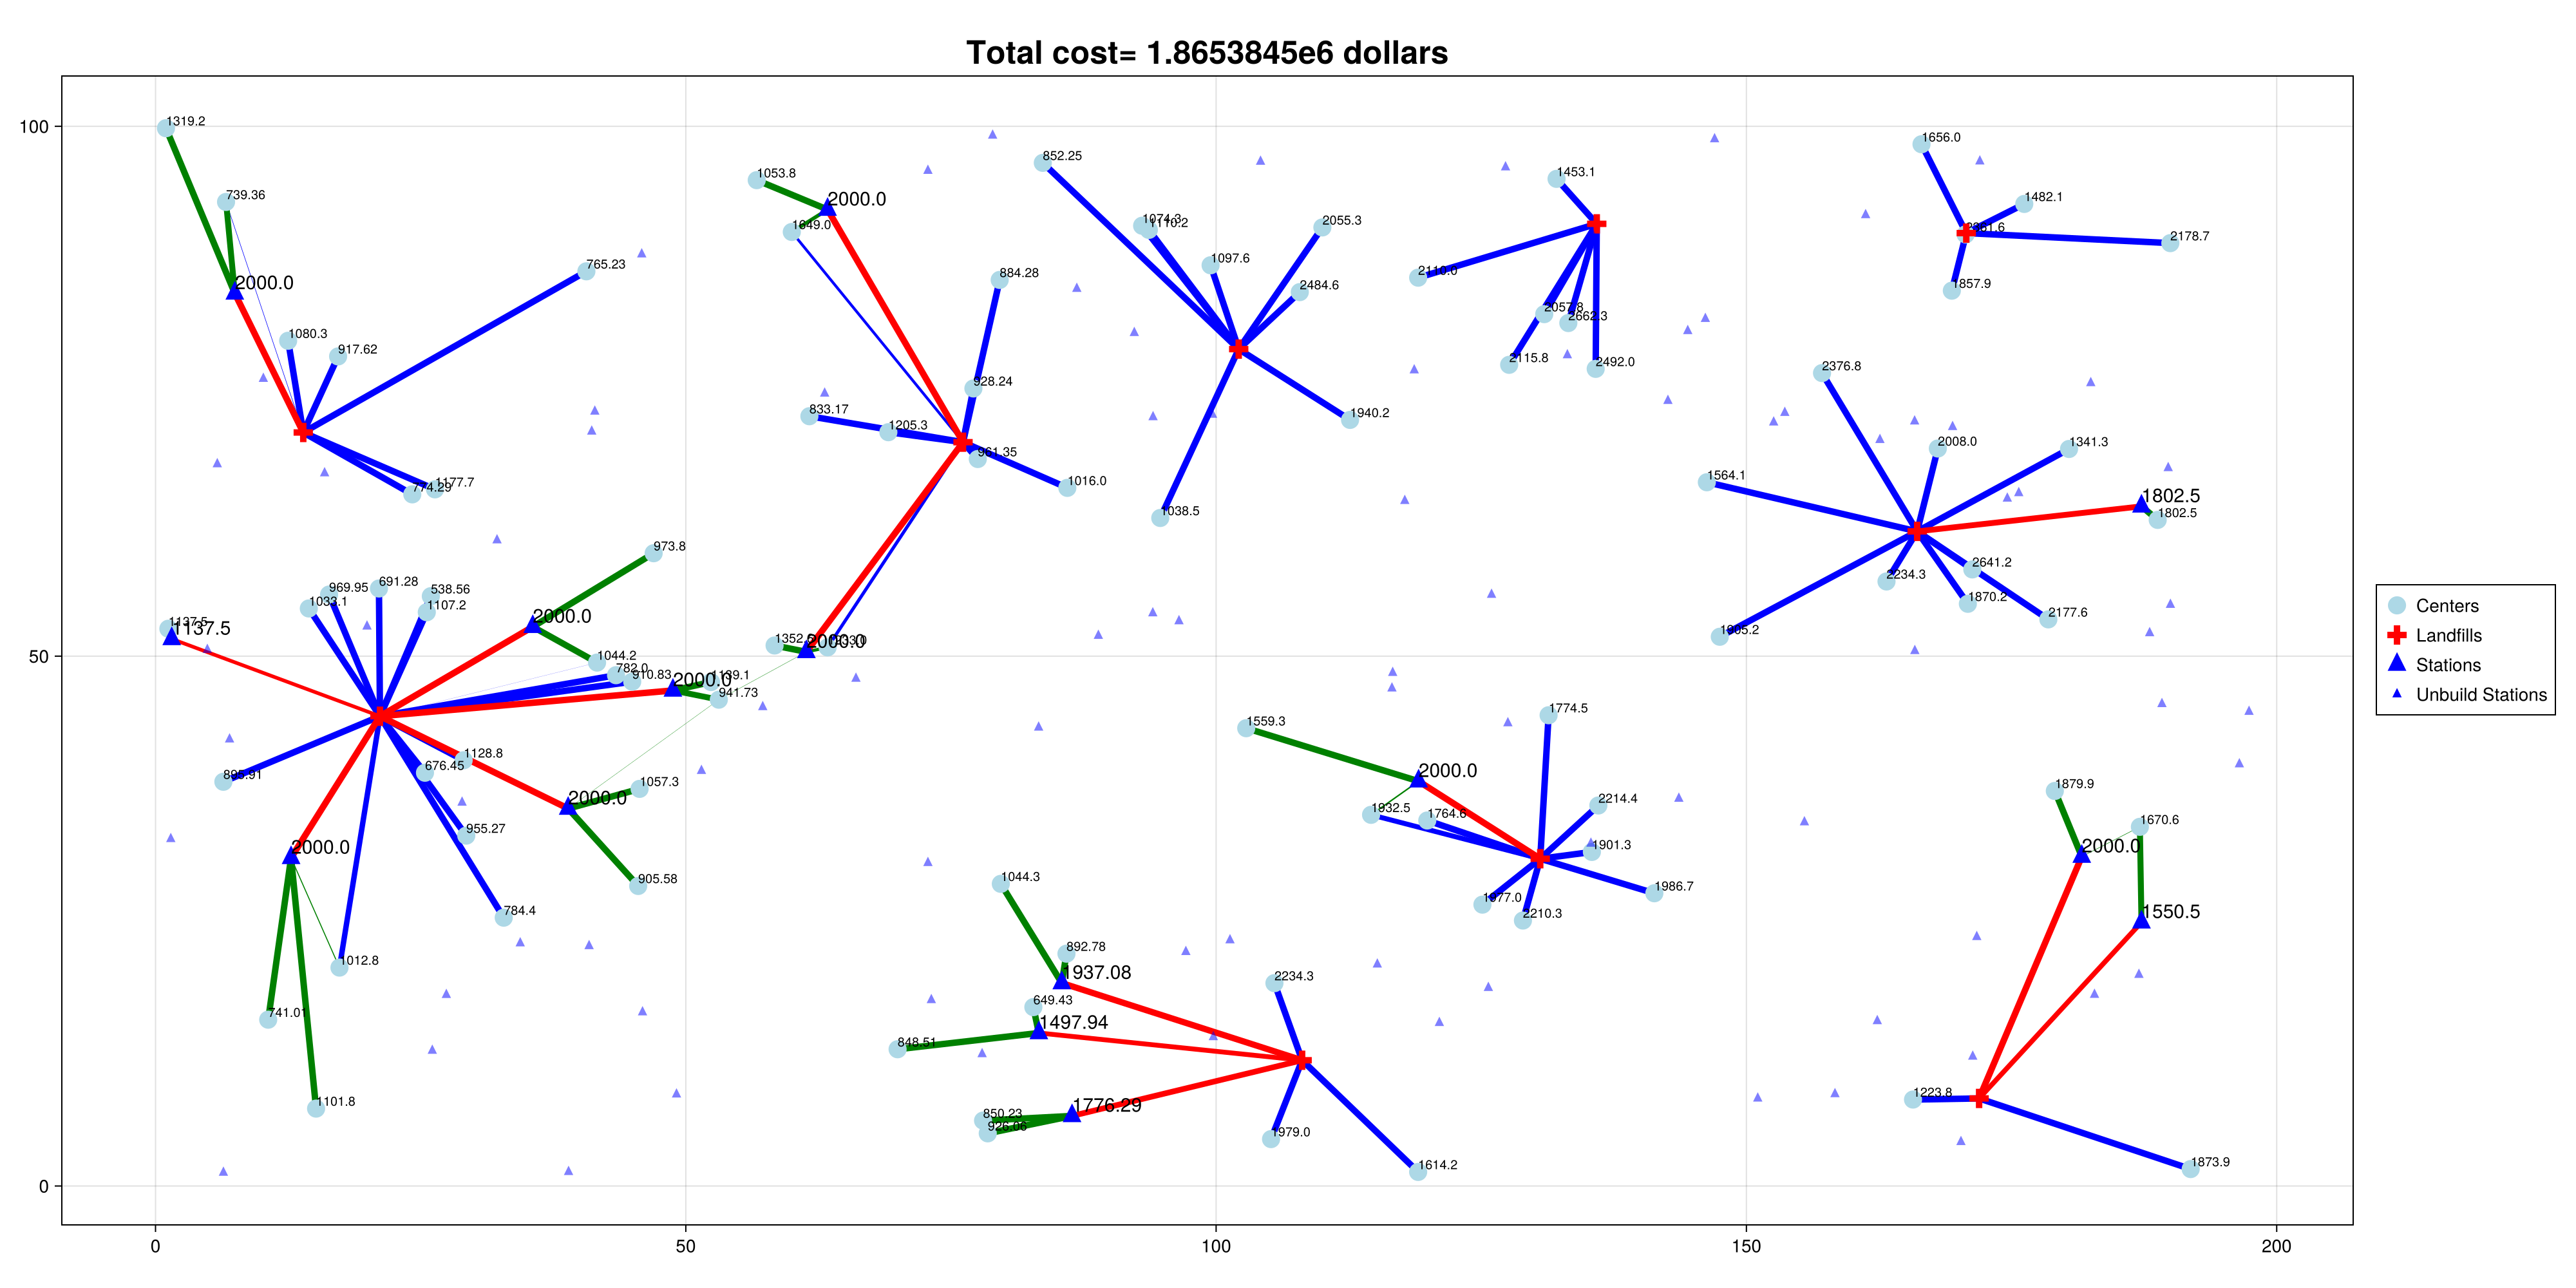

CairoMakie.Screen{IMAGE}


In [26]:
f_Cf, ax_c = visualize_result(modelC_f, centers_total, landfills_total, stations_total, built_landfills_total, built_stations_total, q_total, c2l, c2s, s2l, sx = 2000)
display(f_Cf, inline = true)

In [29]:
@show objective_value(modelB)
@show objective_value(modelC)
@show cost_separated = objective_value(modelB)+ objective_value(modelC)
@show objective_value(modelC_f)
@show (cost_separated- objective_value(modelC_f))/cost_separated*100
@show daily_cost = 10000*sum(value.(z))
@show  daily_cost / objective_value(modelC_f) *100

objective_value(modelB) = 808642.7541913454
objective_value(modelC) = 1.1517612304605762e6
cost_separated = objective_value(modelB) + objective_value(modelC) = 1.9604039846519218e6
objective_value(modelC_f) = 1.8653845034414507e6
((cost_separated - objective_value(modelC_f)) / cost_separated) * 100 = 4.8469336909321905
daily_cost = 10000 * sum(value.(z)) = 150000.0000000566
(daily_cost / objective_value(modelC_f)) * 100 = 8.041237595965946


8.041237595965946

In [28]:
save( "figAb.png", f_A)
save( "figBd.png", f_B)
save( "figCe.png", f_C)
save( "figCf.png", f_Cf)

CairoMakie.Screen{IMAGE}
